# Image Classification - Watch or Not-Watch

There are 4 components to this project:
- This Notebook for main exploration
- flask app (run_server.py and myapp.py)
- quality_detection.py which contains functions for image quality
- Model Fine-tuning notebook
- Sample training images (notebook used to generate training/test data from Avito kaggle competition)

to run the model, please create virtual env in python 3.6 and install libraries as par requirements.txt or just run setup.sh as instructed in readme

In [18]:
import keras
from keras.applications import ResNet50
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
from keras.utils.data_utils import get_file
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import flask
import io
import os
import re
import math, re, os, io
from scipy import stats
import cv2
import quality_detection

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

## Quality Detection

#### See quality_detection.py for the functions I created.

#### please note that quality detection work is WIP in early stage. I would recommend using deep learning based model such as NIMA by google instead of what I have shown here. In fact, the way I converted the 4 metrics into quality score do not actually work... I am leaving this work here as a reference for others.

- For example of critical limitations in this work - more contrast is translated to a higher quality. Obviously, this is not true - there is probably a sweet spot in terms of contrast. Neither too much nor too little contrast is good.

##### Here are the 4 metrics I included in this work:
- Blur (laplacian variance)
- Contrast (entropy of gray scale)
- image shape
- dullness

I consolidate these 4 metrics into 1 by taking simple mean.

In [4]:
def get_model():
    global model
    model = ResNet50(weights="imagenet")

In [5]:
def image2resized_array(image, target):
    # if the image mode is not RGB, convert it
    if image.mode != "RGB":
        image = image.convert("RGB")

    # resize the input image and preprocess it
    image = image.resize(target)
    image = img_to_array(image)
    return image

def imagenet_format(image):
    image = np.expand_dims(image, axis=0)
    image = imagenet_utils.preprocess_input(image)

    # return the processed image
    return image

## Algorithm Evaluation
I collected random labelled data from Avito kaggle competitions, 60 in total (20 pos, 40 negative). In practice, we should collect more samples in order to gain more confident results.

Since this is a binary classification where performance for positive class is the relevant part (much like one-vs-all), I focused on metrics for positive (ie, watch class).
Here are the metrics I used:
- Precision, recall and f1 scores
- confusion metrics
- roc auc score (for examining the probability scores and how sensitive the classifier is to thresholds)

In [160]:
test_result = []
dir_name = 'labels/test/watch'
for img in os.listdir(dir_name):
    image = Image.open(dir_name+'/'+img)
    image = image2resized_array(image, target=(224, 224))
    image = imagenet_format(image)
    preds = model.predict(image)
    results = process_clock_proba(preds, clock_mask)
    r = {"file": img, "correct_label": 1, "pred_label": results[0], "probability": round(results[1],4)}
    test_result.append(r)

dir_name = 'labels/test/notwatch'
for img in os.listdir(dir_name):
    image = Image.open(dir_name+'/'+img)
    image = image2resized_array(image, target=(224, 224))
    image = imagenet_format(image)
    preds = model.predict(image)
    results = process_clock_proba(preds, clock_mask)
    r = {"file": img, "correct_label": 0, "pred_label": results[0], "probability": round(results[1],4)}
    test_result.append(r)


In [170]:
from keras.models import load_model
new_model = load_model('model_watch.h5')

In [171]:
dir_name = 'images_mix'
files = [x for x in os.listdir(dir_name) if x.endswith('.jpg')]

sampled_files = np.random.choice(files, size=16, replace=False)
data = {"success": False}
data["predictions"] = []
for img in sampled_files:
    print(img)
    image = Image.open(dir_name+'/'+img)
    
    quality_score = quality_detection.image_quality_detection(image, mode='score')
    
    image = image2resized_array(image, target=(224, 224))
    image = imagenet_format(image)
    
    preds = new_model.predict(image)[0][0]
    pred_label = 1 if preds>=0.5 else 0

    r = {"label": pred_label, "probability": round(preds,3), \
         "quality": quality_score}
    data["predictions"].append(r)


3942299667.jpg
27055_0.jpg
3838058915.jpg
3669589475.jpg
3273717483.jpg
3522006226.jpg
39889_0.jpg
26979_0.jpg
3933700516.jpg
3546483030.jpg
3264413391.jpg
3784517917.jpg
75736_0.jpg
61758_0.jpg
3857556757.jpg
39871_0.jpg


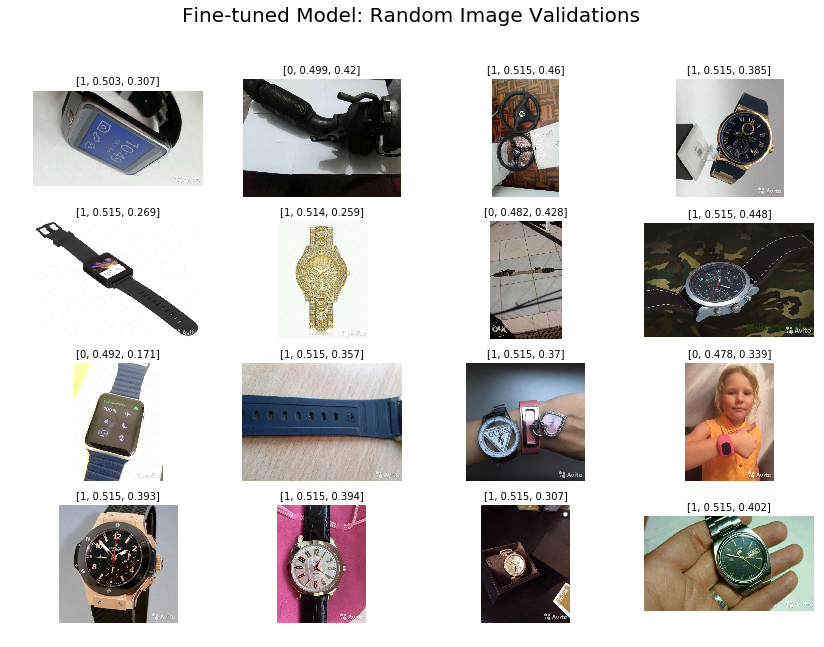

In [163]:
plt.figure(figsize=(14,10))
plt.suptitle('Fine-tuned Model: Random Image Validations', fontsize=20)
for i, img in enumerate(sampled_files):
    img=mpimg.imread(dir_name+'/'+img)
    fig = plt.subplot(4,4,i+1)
    plt.title(list(data['predictions'][i].values()), fontsize=10)
    plt.imshow(img)
    plt.axis('off')

In [175]:
test_result = []
dir_name = 'labels/test/watch'
for img in os.listdir(dir_name):
    image = Image.open(dir_name+'/'+img)
    image = image2resized_array(image, target=(224, 224))
    image = imagenet_format(image)
    preds = new_model.predict(image)[0][0]
    pred_label = 1 if preds>=0.5 else 0
    r = {"file": img, "correct_label": 1, "pred_label": pred_label, "probability": preds}
    test_result.append(r)
    
dir_name = 'labels/test/notwatch'
for img in os.listdir(dir_name):
    image = Image.open(dir_name+'/'+img)
    image = image2resized_array(image, target=(224, 224))
    image = imagenet_format(image)
    preds = new_model.predict(image)[0][0]
    pred_label = 1 if preds>=0.5 else 0
    r = {"file": img, "correct_label": 0, "pred_label": pred_label, "probability": preds}
    test_result.append(r)

In [2]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
y_true = [x['correct_label'] for x in test_result]
y_pred = [x['pred_label'] for x in test_result]
y_score = [x['probability']*x['pred_label']+(1-x['probability'])*(1-x['pred_label'])  for x in test_result]
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print('precision = ' + str(precision))
print('recall = ' + str(recall))
print('f1 score = ' + str(f1))

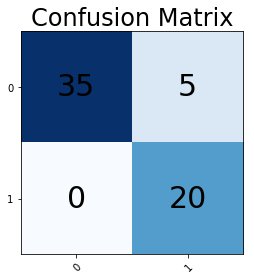

In [177]:
cnf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cnf_matrix, cmap=plt.cm.Blues)

# We want to show all ticks...
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
# ... and label them with the respective list entries
ax.set_xticklabels([0,1])
ax.set_yticklabels([0,1])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cnf_matrix[i, j],
                       ha="center", va="center", color="black", fontsize=30)

ax.set_title("Confusion Matrix", fontsize=24)
fig.tight_layout()
plt.show()

## Test API

Steps for running and requesting API calls through curl
1. Activate virtual env for the app project
2. python run_server.py
3. You can access curl -X POST -F image=@images_mix/3256504841.jpg 'http://localhost:5000/predict'

In [178]:
import requests
KERAS_REST_API_URL = "http://localhost:5000/predict"

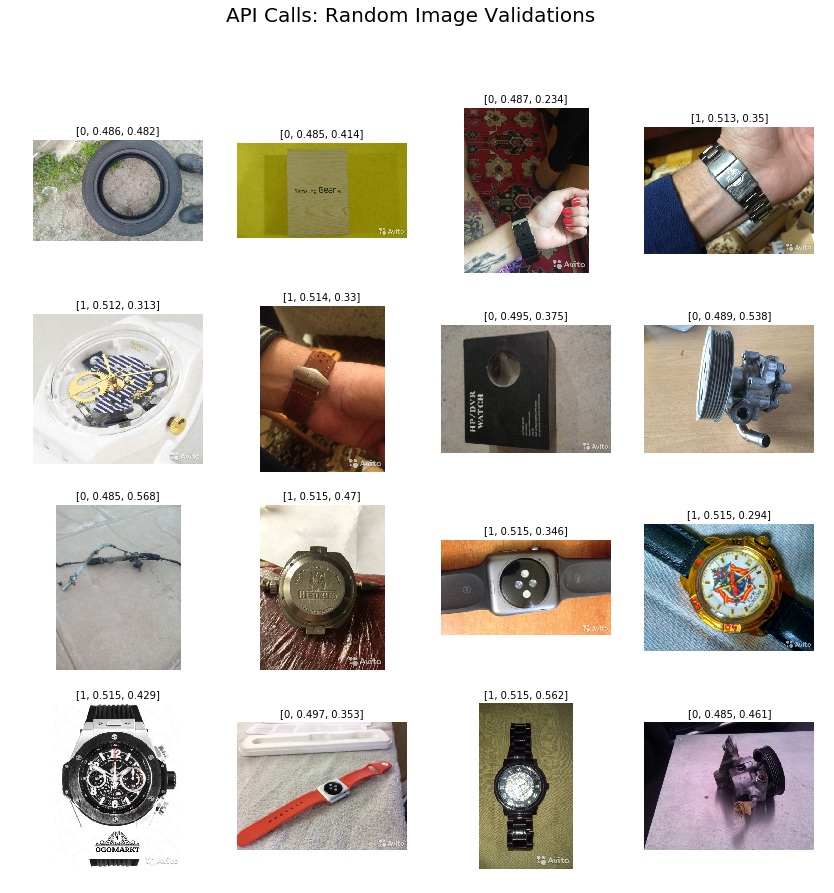

In [158]:
plt.figure(figsize=(14,14))
plt.suptitle('API Calls: Random Image Validations', fontsize=20)
for i, img in enumerate(sampled_files):
    IMAGE_PATH = "images_mix/" + img
    image = open(IMAGE_PATH, "rb").read()
    payload = {"image": image}
    r = requests.post(KERAS_REST_API_URL, files=payload).json()
    
    img=mpimg.imread(IMAGE_PATH)
    fig = plt.subplot(4,4,i+1)
    plt.title(list(r.values()), fontsize=10)
    plt.imshow(img)
    plt.axis('off')